
## Business problem
Italian cuisine is undoubtly one of most famous cuisine. However, from the perspective of an investor or a chef dreaming of opening his/her own italian restaurant, it is a remarkable challenge in getting into the market due to the highly saturated supply of Italian food.

The objective of this project is to find the best neighborhood in Toronto to open an Italian restaurant. In this project, we'll be trying to find ideal places to start a Italian restaurant using Foursquare location data and clustering analysis.

## Target Audience
Italian  chef's trying to open their own restaurant.
Investors looking to establish a business related to Italian  food.
Tourists who are interested in Italian  cuisine.

**Importing libraries**

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
import seaborn as sns
# For graph and folium colors
import matplotlib.pyplot  as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Libraries imported.')

/bin/bash: conda: command not found
Libraries imported.


**Scraping Webpage**

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [3]:
table_contents=[]
table=wiki_data.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

Postal Code           Borough                      Neighborhood
0         M3A        North York                         Parkwoods
1         M4A        North York                  Victoria Village
2         M5A  Downtown Toronto         Regent Park, Harbourfront
3         M6A        North York  Lawrence Manor, Lawrence Heights
4         M7A      Queen's Park     Ontario Provincial Government

In [4]:
df.shape

(103, 3)

**Adding Geographical Location**

**Using the csv file for getting the latitude and longitude**

In [5]:
data = pd.read_csv('Geospatial_Coordinates.csv')
data.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

**Merging the two dataframes into one**

In [6]:
dataframe = pd.merge(df, data, on = 'Postal Code')
dataframe.head()

Postal Code           Borough                      Neighborhood   Latitude  \
0         M3A        North York                         Parkwoods  43.753259   
1         M4A        North York                  Victoria Village  43.725882   
2         M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3         M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4         M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [7]:
dataframe.shape

(103, 5)

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(dataframe['Borough'].unique()),
        dataframe.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


In [9]:
# lets find out how many neighborhoods in each borough
dataframe.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

**It is important to take note that there are actually quite a lot of boroughs in the data set.**
**In this project we will only focus on toronto area.**
**Let's create a filter to only accomodate the Toronto area in general.**

**Use geopy library to get the latitude and longitude values of Toronto, Canada and Create a map of Toronto with neighborhoods superimposed on top.**

In [10]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


In [11]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Borough'], dataframe['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_Toronto)  
    
map_Toronto

**Filter the dataframe to only contain the "Toronto" indentifier**

In [12]:

toronto_data = dataframe[dataframe['Borough'].str.contains("Toronto")].reset_index()
neighborhoods = toronto_data

In [13]:
neighborhoods

index Postal Code                 Borough  \
0       2         M5A        Downtown Toronto   
1       9         M5B        Downtown Toronto   
2      15         M5C        Downtown Toronto   
3      19         M4E            East Toronto   
4      20         M5E        Downtown Toronto   
5      24         M5G        Downtown Toronto   
6      25         M6G        Downtown Toronto   
7      30         M5H        Downtown Toronto   
8      31         M6H            West Toronto   
9      35         M4J  East York/East Toronto   
10     36         M5J        Downtown Toronto   
11     37         M6J            West Toronto   
12     41         M4K            East Toronto   
13     42         M5K        Downtown Toronto   
14     43         M6K            West Toronto   
15     47         M4L            East Toronto   
16     48         M5L        Downtown Toronto   
17     54         M4M            East Toronto   
18     61         M4N         Central Toronto   
19     62         M5N         Central Toronto   
20     67         M4P         Central Toronto   
21     68         M5P         Central Toronto   
22     69         M6P            West Toronto   
23     73         M4R         Central Toronto   
24     74         M5R         Central Toronto   
25     75         M6R            West Toronto   
26     79         M4S         Central Toronto   
27     80         M5S        Downtown Toronto   
28     81         M6S            West Toronto   
29     83         M4T         Central Toronto   
30     84         M5T        Downtown Toronto   
31     86         M4V         Central Toronto   
32     87         M5V        Downtown Toronto   
33     91         M4W        Downtown Toronto   
34     92         M5W  Downtown Toronto Stn A   
35     96         M4X        Downtown Toronto   
36     97         M5X        Downtown Toronto   
37     99         M4Y        Downtown Toronto   
38    100         M7Y   East Toronto Business   

                                         Neighborhood   Latitude  Longitude  
0                           Regent Park, Harbourfront  43.654260 -79.360636  
1                            Garden District, Ryerson  43.657162 -79.378937  
2                                      St. James Town  43.651494 -79.375418  
3                                         The Beaches  43.676357 -79.293031  
4                                         Berczy Park  43.644771 -79.373306  
5                                  Central Bay Street  43.657952 -79.387383  
6                                            Christie  43.669542 -79.422564  
7                            Richmond, Adelaide, King  43.650571 -79.384568  
8                        Dufferin, Dovercourt Village  43.669005 -79.442259  
9                                  The Danforth  East  43.685347 -79.338106  
10  Harbourfront East, Union Station, Toronto Islands  43.640816 -79.381752  
11                           Little Portugal, Trinity  43.647927 -79.419750  
12                       The Danforth West, Riverdale  43.679557 -79.352188  
13           Toronto Dominion Centre, Design Exchange  43.647177 -79.381576  
14       Brockton, Parkdale Village, Exhibition Place  43.636847 -79.428191  
15                     India Bazaar, The Beaches West  43.668999 -79.315572  
16                     Commerce Court, Victoria Hotel  43.648198 -79.379817  
17                                    Studio District  43.659526 -79.340923  
18                                      Lawrence Park  43.728020 -79.388790  
19                                           Roselawn  43.711695 -79.416936  
20                                   Davisville North  43.712751 -79.390197  
21                           Forest Hill North & West  43.696948 -79.411307  
22                      High Park, The Junction South  43.661608 -79.464763  
23                                 North Toronto West  43.715383 -79.405678  
24                The Annex, North Midtown, Yorkville  43.672710 -79.405678  
25             

**Define Foursquare Credentials and Version**

In [14]:
CLIENT_ID = 'RPBGIJR00IOXKSES43JRMD1HKQLBVRL3WLB5F3JZRJGFB3O1' # your Foursquare ID
CLIENT_SECRET = 'VP55O1LOPYFBUL40KOUNVJNKK1SSTCYMSKYKMC2FV5T3TFZD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RPBGIJR00IOXKSES43JRMD1HKQLBVRL3WLB5F3JZRJGFB3O1
CLIENT_SECRET:VP55O1LOPYFBUL40KOUNVJNKK1SSTCYMSKYKMC2FV5T3TFZD


**Venue explorer**

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
            except:
                pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # Summary of results in dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [16]:
toronto_venues = getNearbyVenues(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'])
print(toronto_venues.shape)

(1589, 7)


In [17]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques vanue categories.


**Transform the data set into a one-hot encoding style**

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Yoga Studio  Adult Boutique  Airport  Airport Food Court  Airport Gate  \
0            0               0        0                   0             0   
1            0               0        0                   0             0   
2            0               0        0                   0             0   
3            0               0        0                   0             0   
4            0               0        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0             0         0            0           0                    0   
1             0         0            0           0                    0   
2             0         0            0           0                    0   
3             0         0            0           0                    0   
4             0         0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  \
0                 0                   0              0          0           0   
1                 0                   0              0          0           0   
2                 0                   0              0          0           0   
3                 0                   0              0          0           0   
4                 0                   0              0          0           0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Stadium  Basketball Stadium  Beach  \
0           0       1     0    0                 0                   0      0   
1           0       0     0    0                 0                   0      0   
2           0       0     0    0                 0                   0      0   
3           0       0     0    0                 0                   0      0   
4           0       0     0    0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0                0         0           0                   0       0   
1                0         0           0                   0       0   
2                0         0           0                   0       0   
3                0         0           0                   0       0   
4                0         0           0                   0       0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0           0              0          0         0                     0   
1           0              0          0         0                     0   
2           0              0          0         0                     0   
3           0              0          0         0                     0   
4           0              0          0         0                     0   

   Breakfast Spot  Brewery  Bubble Tea Shop  Building  Burger Joint  \
0               0        0                0         0             0   
1               0        0                0         0             0   
2               0        0                0         0             0   
3               0        0                0         0             0   
4               0        0                0         0             0   

   Burrito Place  Bus Line  Butcher  Café  Cajun / Creole Restaurant  \
0              0         0        0     0                          0   
1              0         0        0     0                          0   
2              0         0        0     0                          0   
3              0         0        0     0            

In [19]:

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Yoga Studio  \
0                                        Berczy Park     0.000000   
1       Brockton, Parkdale Village, Exhibition Place     0.041667   
2  CN Tower, King and Spadina, Railway Lands, Har...     0.000000   
3                                 Central Bay Street     0.015873   
4                                           Christie     0.000000   

   Adult Boutique   Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0             0.0  0.000000            0.000000      0.000000        0.000000   
1             0.0  0.000000            0.000000      0.000000        0.000000   
2             0.0  0.055556            0.055556      0.055556        0.111111   
3             0.0  0.000000            0.000000      0.000000        0.000000   
4             0.0  0.000000            0.000000      0.000000        0.000000   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0         0.000000          0.000000                  0.0           0.0   
1         0.000000          0.000000                  0.0           0.0   
2         0.166667          0.111111                  0.0           0.0   
3         0.000000          0.000000                  0.0           0.0   
4         0.000000          0.000000                  0.0           0.0   

   Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0       0.0     0.017241    0.000000                  0.0               0.0   
1       0.0     0.000000    0.000000                  0.0               0.0   
2       0.0     0.000000    0.000000                  0.0               0.0   
3       0.0     0.000000    0.015873                  0.0               0.0   
4       0.0     0.000000    0.000000                  0.0               0.0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  \
0              0.0000            0.0        0.0      0.0000    0.017241   
1              0.0000            0.0        0.0      0.0000    0.000000   
2              0.0000            0.0        0.0      0.0000    0.000000   
3              0.0000            0.0        0.0      0.0000    0.000000   
4              0.0625            0.0        0.0      0.0625    0.000000   

     Bakery      Bank       Bar  Baseball Stadium  Basketball Stadium  \
0  0.051724  0.000000  0.000000               0.0            0.017241   
1  0.041667  0.000000  0.041667               0.0            0.000000   
2  0.000000  0.000000  0.055556               0.0            0.000000   
3  0.000000  0.015873  0.015873               0.0            0.000000   
4  0.000000  0.000000  0.000000               0.0            0.000000   

      Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0  0.017241              0.0  0.034483         0.0                 0.0   
1  0.000000              0.0  0.000000         0.0                 0.0   
2  0.000000              0.0  0.000000         0.0                 0.0   
3  0.000000              0.0  0.000000         0.0                 0.0   
4  0.000000              0.0  0.000000         0.0                 0.0   

     Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0  0.017241         0.0       0.000000   0.000000  0.000000   
1  0.000000         0.0       0.000000   0.000000  0.000000   
2  0.000000         0.0       0.055556   0.000000  0.055556   
3  0.000000         0.0       0.000000   0.015873  0.000000   
4  0.000000         0.0       0.000000   0.000000  0.000000   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  Building  \
0                   0.0        0.017241      0.0         0.000000       0.0   
1                   0.0        0.083333      0.0         0.000000       0.0   
2                   0.0        0.000000      0.0         0.000000       0.0   
3                   0.0        0.000000      0.0         0.031746       0.0   
4                   0.0        0.000000      0.0         0.000000       0.0   

   Burger Joint  Burrit

**Taking account of only Italian restaurants**

In [20]:
jap = toronto_grouped[["Neighborhood","Italian Restaurant"]]
jap

Neighborhood  Italian Restaurant
0                                         Berczy Park            0.017241
1        Brockton, Parkdale Village, Exhibition Place            0.041667
2   CN Tower, King and Spadina, Railway Lands, Har...            0.000000
3                                  Central Bay Street            0.047619
4                                            Christie            0.062500
5                                Church and Wellesley            0.012658
6                      Commerce Court, Victoria Hotel            0.030000
7                                          Davisville            0.057143
8                                    Davisville North            0.000000
9                        Dufferin, Dovercourt Village            0.000000
10                                     Enclave of M4L            0.000000
11                                     Enclave of M5E            0.041237
12             First Canadian Place, Underground city            0.010000
13                           Forest Hill North & West            0.000000
14                           Garden District, Ryerson            0.020000
15  Harbourfront East, Union Station, Toronto Islands            0.030000
16                      High Park, The Junction South            0.041667
17                     India Bazaar, The Beaches West            0.055556
18          Kensington Market, Chinatown, Grange Park            0.014925
19                                      Lawrence Park            0.000000
20                           Little Portugal, Trinity            0.024390
21                                 North Toronto West            0.052632
22                             Parkdale, Roncesvalles            0.071429
23                          Regent Park, Harbourfront            0.000000
24                           Richmond, Adelaide, King            0.000000
25                                           Rosedale            0.000000
26                                           Roselawn            0.000000
27                                 Runnymede, Swansea            0.058824
28                                     St. James Town            0.024096
29                        St. James Town, Cabbagetown            0.043478
30                                    Studio District            0.027778
31  Summerhill West, Rathnelly, South Hill, Forest...            0.000000
32                The Annex, North Midtown, Yorkville            0.000000
33                                        The Beaches            0.000000
34                                 The Danforth  East            0.000000
35                       The Danforth West, Riverdale            0.071429
36           Toronto Dominion Centre, Design Exchange            0.030000
37                     University of Toronto, Harbord            0.028571

**Optimal K value
We need to examine what is the optimal K value for the K-means clustering.
Basically, we will be testing out multiple K values and using the Elbow method to determine the most optimal.**

Text(0.5, 1.0, 'The Elbow Method using Inertia')

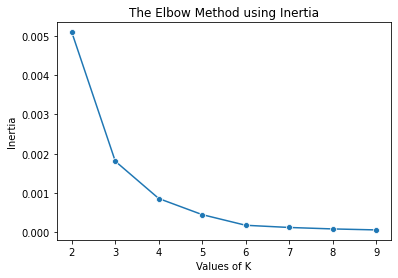

In [21]:

def clustering(data,kclusters: int):
    data_clustering = data
    kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(data_clustering)
    return kmeans_model

k = []
inertia = []

for i in range(2,10):
    data = jap.drop(['Neighborhood'], axis=1)
    model = clustering(data, i)
    
    k.append(i)
    inertia.append(model.inertia_)
    
sns.lineplot(x = k, y=inertia, marker='o', dashes=False)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

**It appears that K=4 is the inflection point of the graph hence our optimal K value.
We use K=4 for the succeeding K=means clustering**

**K-means clustering**

In [22]:
kclusters = 4

toronto_grouped_clustering = jap.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 1, 3, 0, 1, 2, 0, 1, 1], dtype=int32)

In [23]:
# create a new dataframe that includes the cluster 
to_merged = jap.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

to_merged

Neighborhood  Italian Restaurant  \
0                                         Berczy Park            0.017241   
1        Brockton, Parkdale Village, Exhibition Place            0.041667   
2   CN Tower, King and Spadina, Railway Lands, Har...            0.000000   
3                                  Central Bay Street            0.047619   
4                                            Christie            0.062500   
5                                Church and Wellesley            0.012658   
6                      Commerce Court, Victoria Hotel            0.030000   
7                                          Davisville            0.057143   
8                                    Davisville North            0.000000   
9                        Dufferin, Dovercourt Village            0.000000   
10                                     Enclave of M4L            0.000000   
11                                     Enclave of M5E            0.041237   
12             First Canadian Place, Underground city            0.010000   
13                           Forest Hill North & West            0.000000   
14                           Garden District, Ryerson            0.020000   
15  Harbourfront East, Union Station, Toronto Islands            0.030000   
16                      High Park, The Junction South            0.041667   
17                     India Bazaar, The Beaches West            0.055556   
18          Kensington Market, Chinatown, Grange Park            0.014925   
19                                      Lawrence Park            0.000000   
20                           Little Portugal, Trinity            0.024390   
21                                 North Toronto West            0.052632   
22                             Parkdale, Roncesvalles            0.071429   
23                          Regent Park, Harbourfront            0.000000   
24                           Richmond, Adelaide, King            0.000000   
25                                           Rosedale            0.000000   
26                                           Roselawn            0.000000   
27                                 Runnymede, Swansea            0.058824   
28                                     St. James Town            0.024096   
29                        St. James Town, Cabbagetown            0.043478   
30                                    Studio District            0.027778   
31  Summerhill West, Rathnelly, South Hill, Forest...            0.000000   
32                The Annex, North Midtown, Yorkville            0.000000   
33                                        The Beaches            0.000000   
34                                 The Danforth  East            0.000000   
35                       The Danforth West, Riverdale            0.071429   
36           Toronto Dominion Centre, Design Exchange            0.030000   
37                     University of Toronto, Harbord            0.028571   

    Cluster Labels  
0                2  
1                3  
2                1  
3                3  
4                0  
5                1  
6                2  
7                0  
8                1  
9                1  
10               1  
11               3  
12               1  
13               1  
14               2  
15               2  
16               3  
17               0  
18               2  
19               1  
20               2  
21               3  
22               0  
23               1  
24               1  
25               1  
26               1  
27               0  
28               2  
29               3  
30               2  
31               1  
32               1  
33               1  
34               1  
35               0  
36               2  
37               2

In [24]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1589, 9)


Neighborhood  Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
0  Berczy Park            0.017241               2              43.644771   
0  Berczy Park            0.017241               2              43.644771   
0  Berczy Park            0.017241               2              43.644771   
0  Berczy Park            0.017241               2              43.644771   
0  Berczy Park            0.017241               2              43.644771   

   Neighborhood Longitude                                 Venue  \
0              -79.373306                                  LCBO   
0              -79.373306  The Keg Steakhouse + Bar - Esplanade   
0              -79.373306                        Fresh On Front   
0              -79.373306                Goose Island Brewhouse   
0              -79.373306                           Berczy Park   

   Venue Latitude  Venue Longitude                 Venue Category  
0       43.642944       -79.372440                   Liquor Store  
0       43.646712       -79.374768                     Restaurant  
0       43.647815       -79.374453  Vegetarian / Vegan Restaurant  
0       43.647329       -79.373541                       Beer Bar  
0       43.648048       -79.375172                           Park

In [25]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(1589, 9)


Neighborhood  Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
11  Enclave of M5E            0.041237               3              43.646435   
11  Enclave of M5E            0.041237               3              43.646435   
11  Enclave of M5E            0.041237               3              43.646435   
11  Enclave of M5E            0.041237               3              43.646435   
11  Enclave of M5E            0.041237               3              43.646435   

    Neighborhood Longitude                   Venue  Venue Latitude  \
11              -79.374846               CC Lounge       43.647917   
11              -79.374846       Petit Four Bakery       43.647744   
11              -79.374846         Air Canada Club       43.643224   
11              -79.374846          The Optic Zone       43.649730   
11              -79.374846  Woods Restaurant & Bar       43.649357   

    Venue Longitude                   Venue Category  
11       -79.374520                     Cocktail Bar  
11       -79.379588                   Sandwich Place  
11       -79.379159                           Lounge  
11       -79.371702                     Optical Shop  
11       -79.375002  Molecular Gastronomy Restaurant

In [26]:
# Check how many Italian restaurant entries we have. 
to_merged['Venue Category'].value_counts()['Italian Restaurant']

42

**Visualizing the division**

In [27]:
# create map
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


**The No. of neighborhood per cluster**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'No. of Neighborhoods')

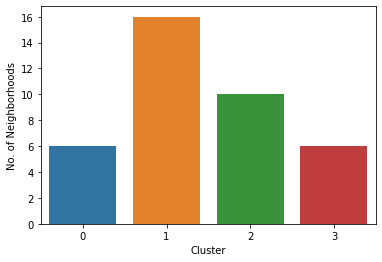

In [28]:
jap["Cluster Labels"] = kmeans.labels_
# ita.head()

objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = jap['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()

# plt.figure(figsize=(8, 4))
ax = sns.barplot(x=y_pos, y=perf)
plt.xlabel("Cluster")
plt.ylabel("No. of Neighborhoods")

In [29]:
df_new = dataframe[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

**Identifying four different clusters**

In [30]:

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
cluster1.head()

Borough Neighborhood  Italian Restaurant  Cluster Labels  \
0  Downtown Toronto     Christie              0.0625               0   
1  Downtown Toronto     Christie              0.0625               0   
2  Downtown Toronto     Christie              0.0625               0   
3  Downtown Toronto     Christie              0.0625               0   
4  Downtown Toronto     Christie              0.0625               0   

   Neighborhood Latitude  Neighborhood Longitude                 Venue  \
0              43.669542              -79.422564           Queens Club   
1              43.669542              -79.422564          Dupont Disco   
2              43.669542              -79.422564  Marlenes Just Babies   
3              43.669542              -79.422564         Sobeys Dupont   
4              43.669542              -79.422564               Loblaws   

   Venue Latitude  Venue Longitude      Venue Category  
0       43.672386       -79.418106  Athletics & Sports  
1       43.670490       -79.426611           Nightclub  
2       43.671824       -79.420499          Baby Store  
3       43.670977       -79.427573       Grocery Store  
4       43.671657       -79.421364       Grocery Store

In [31]:
cluster2 = to_merged.loc[to_merged['Cluster Labels'] == 1]
cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
cluster2.head()

Borough               Neighborhood  Italian Restaurant  \
0  Downtown Toronto  Regent Park, Harbourfront                 0.0   
1  Downtown Toronto  Regent Park, Harbourfront                 0.0   
2  Downtown Toronto  Regent Park, Harbourfront                 0.0   
3  Downtown Toronto  Regent Park, Harbourfront                 0.0   
4  Downtown Toronto  Regent Park, Harbourfront                 0.0   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               1               43.65426              -79.360636   
1               1               43.65426              -79.360636   
2               1               43.65426              -79.360636   
3               1               43.65426              -79.360636   
4               1               43.65426              -79.360636   

                Venue  Venue Latitude  Venue Longitude Venue Category  
0     ODIN Cafe + Bar       43.656739       -79.356503           Café  
1     Berkeley Church       43.655123       -79.365873    Event Space  
2          The Aviary       43.653634       -79.354662            Pub  
3  Soulpepper Theatre       43.650780       -79.357615        Theater  
4         Caffe Furbo       43.649970       -79.358849           Café

In [32]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
cluster3


Borough                                       Neighborhood  \
0    Downtown Toronto                           Garden District, Ryerson   
1    Downtown Toronto                           Garden District, Ryerson   
2    Downtown Toronto                           Garden District, Ryerson   
3    Downtown Toronto                           Garden District, Ryerson   
4    Downtown Toronto                           Garden District, Ryerson   
5    Downtown Toronto                           Garden District, Ryerson   
6    Downtown Toronto                           Garden District, Ryerson   
7    Downtown Toronto                           Garden District, Ryerson   
8    Downtown Toronto                           Garden District, Ryerson   
9    Downtown Toronto                           Garden District, Ryerson   
10   Downtown Toronto                           Garden District, Ryerson   
11   Downtown Toronto                           Garden District, Ryerson   
12   Downtown Toronto                           Garden District, Ryerson   
13   Downtown Toronto                           Garden District, Ryerson   
14   Downtown Toronto                           Garden District, Ryerson   
15   Downtown Toronto                           Garden District, Ryerson   
16   Downtown Toronto                           Garden District, Ryerson   
17   Downtown Toronto                           Garden District, Ryerson   
18   Downtown Toronto                           Garden District, Ryerson   
19   Downtown Toronto                           Garden District, Ryerson   
20   Downtown Toronto                           Garden District, Ryerson   
21   Downtown Toronto                           Garden District, Ryerson   
22   Downtown Toronto                           Garden District, Ryerson   
23   Downtown Toronto                           Garden District, Ryerson   
24   Downtown Toronto                           Garden District, Ryerson   
25   Downtown Toronto                           Garden District, Ryerson   
26   Downtown Toronto                           Garden District, Ryerson   
27   Downtown Toronto                           Garden District, Ryerson   
28   Downtown Toronto                           Garden District, Ryerson   
29   Downtown Toronto                           Garden District, Ryerson   
30   Downtown Toronto                           Garden District, Ryerson   
31   Downtown Toronto                           Garden District, Ryerson   
32   Downtown Toronto                           Garden District, Ryerson   
33   Downtown Toronto                           Garden District, Ryerson   
34   Downtown Toronto                           Garden District, Ryerson   
35   Downtown Toronto                           Garden District, Ryerson   
36   Downtown Toronto                           Garden District, Ryerson   
37   Downtown Toronto                           Garden District, Ryerson   
38   Downtown Toronto                           Garden District, Ryerson   
39   Downtown Toronto                           Garden District, Ryerson   
40   Downtown Toronto                           Garden District, Ryerson   
41   Downtown Toronto                           Garden District, Ryerson   
42   Downtown Toronto                           Garden District, Ryerson   
43   Downtown Toronto                           Garden District, Ryerson   
44   Downtown Toronto                           Garden District, Ryerson   
45   Downtown Toronto                           Garden District, Ryerson   
46   Downtown Toronto                           Garden District, Ryerson   
47   Downtown Toronto                           Garden District, Ryerson   
48   Downtown Toronto                           Garden District, Ryerson   
49   Downtown Toronto                           Garden District, Ryerson   
50   Downtown Toronto                           Garden District, Ryerson   
51   Downtown Toronto                           Garden Distric

In [33]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
cluster4

Borough                                  Neighborhood  \
0          Downtown Toronto                            Central Bay Street   
1          Downtown Toronto                            Central Bay Street   
2          Downtown Toronto                            Central Bay Street   
3          Downtown Toronto                            Central Bay Street   
4          Downtown Toronto                            Central Bay Street   
5          Downtown Toronto                            Central Bay Street   
6          Downtown Toronto                            Central Bay Street   
7          Downtown Toronto                            Central Bay Street   
8          Downtown Toronto                            Central Bay Street   
9          Downtown Toronto                            Central Bay Street   
10         Downtown Toronto                            Central Bay Street   
11         Downtown Toronto                            Central Bay Street   
12         Downtown Toronto                            Central Bay Street   
13         Downtown Toronto                            Central Bay Street   
14         Downtown Toronto                            Central Bay Street   
15         Downtown Toronto                            Central Bay Street   
16         Downtown Toronto                            Central Bay Street   
17         Downtown Toronto                            Central Bay Street   
18         Downtown Toronto                            Central Bay Street   
19         Downtown Toronto                            Central Bay Street   
20         Downtown Toronto                            Central Bay Street   
21         Downtown Toronto                            Central Bay Street   
22         Downtown Toronto                            Central Bay Street   
23         Downtown Toronto                            Central Bay Street   
24         Downtown Toronto                            Central Bay Street   
25         Downtown Toronto                            Central Bay Street   
26         Downtown Toronto                            Central Bay Street   
27         Downtown Toronto                            Central Bay Street   
28         Downtown Toronto                            Central Bay Street   
29         Downtown Toronto                            Central Bay Street   
30         Downtown Toronto                            Central Bay Street   
31         Downtown Toronto                            Central Bay Street   
32         Downtown Toronto                            Central Bay Street   
33         Downtown Toronto                            Central Bay Street   
34         Downtown Toronto                            Central Bay Street   
35         Downtown Toronto                            Central Bay Street   
36         Downtown Toronto                            Central Bay Street   
37         Downtown Toronto                            Central Bay Street   
38         Downtown Toronto                            Central Bay Street   
39         Downtown Toronto                            Central Bay Street   
40         Downtown Toronto                            Central Bay Street   
41         Downtown Toronto                            Central Bay Street   
42         Downtown Toronto                            Central Bay Street   
43         Downtown Toronto                            Central Bay Street   
44         Downtown Toronto                            Central Bay Street   
45         Downtown Toronto                            Central Bay Street   
46         Downtown Toronto                            Central Bay Street   
47         Downtown Toronto                            Central Bay Street   
48         Downtown Toronto                            Central Bay Street   
49         Downtown Toronto                            Central Bay Street   
50         Downtown Toronto                            Central Bay Street   
51         Downt

**Now we take a closer look, specifically the number of neighborhoods and italian restaurants per cluster.**

Text(0.5, 1.0, 'Average number of Italian Restaurants per Cluster')

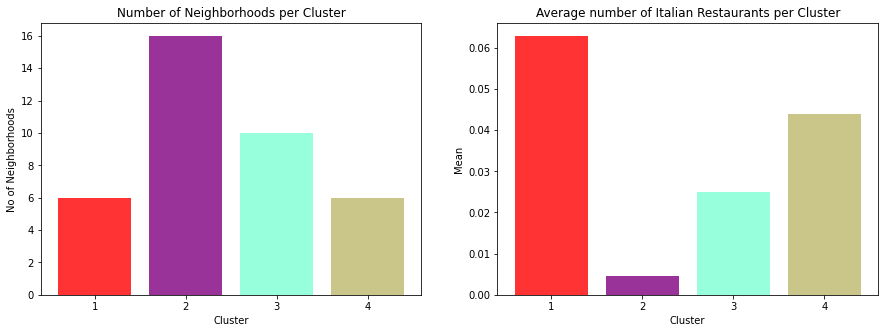

In [34]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = jap['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [cluster1['Italian Restaurant'].mean(),cluster2['Italian Restaurant'].mean(),cluster3['Italian Restaurant'].mean(),
                cluster4['Italian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

****CONCLUSION****


**From the perspective of a tourist, it may be best to go to the neighborhoods in cluster 1. There are a lot of Italian restaurants that will cater to the adventurous pallete.
From the perspective of a businessman, the optimal location to open a new Italian restaurant is in cluster 2, that is neighbourhoods such as Kensington Market, Chinatown, Grange Park, Harbourfront East, Union Station, Toronto Islands,Garden District, Ryerson where there are a lot of potential demands for an Italian restaurant while having the least competition around the vicinity. Of course it might be possible that these neighborhoods are less commercialize as compared to cluster 1.**